# Exercise 1 - Model Predictive Control

In [0]:
# setup matplotlib for nice display in Jupyter
# %matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## Solving a constrained linear optimal control problem

In [0]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Simulation of the LIPM

In [0]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_steps[i]-self.foot_size, foot_steps[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u

## Animation and plotting utility

In [0]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [0]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

## Planning a walking trajectory

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABF4W1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmPZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/k2bTi1K50H6
a/KaDyW+/PojNfjyTTJGCDrUr3/X4Z8ZPR8ghxZNap+CgXFTzbTCri3IFF91aICUm8TrVPI7YOsw
xLVd5TvVrNP/jPpTEx62vpstdartt74uATqbq+qHv3OBtH9/wqbjUaDTHRP2ueYKxi7VVSaTxqNf
eCR3xz51lOXOWYrC2T66rZ7xcLOGsXwieMaRJ/bP9wLIsGaEpGGDn7hW9p555+Q2rHoNd2+xpphN
v5NuO6orDifspAsY1f/a1Yw1SWv6pyW7oqC3bPDjI9n1KuOFfexvWX0NAHC1/mRIhnBvYEA52cSy
cG12Fd+xJlfQcFX6ymPi+R/cl/SNKzKlO+93bqbBWtnVmEd8s0/UQiM9snyyMzA6mjeObWqpypYu
+sE83n8lRkJ+GlM58whJrJYLUDDmqfdHOQ95htAjGrj9D7JufFGVCurXt7aXFDeyZ/eA/HAjZ7P9
Rc0N84ads40R91oxOlXUcDJbtNuNSpSy1Z9sM1stjv2bAwA/BIGt7WX/ouTZEOY4ACqOBYkH9myF
mt8b/qWoHxn/lJLM8J/om357OuzXRJbWdDwoao/aXU/Rm8qJU0XdczaelSuIaEOcu5c+vS0jSQAX
G/tmdsG7kIGJfvgmj6CCav0eBn2XHBaZqX0gOpnv43I3jm0y1BdiP3dNLJe+4DJk1CAGutQjoczP
ecrPqLz/nU5dIaGilwcT/URgsZxlAZdC8fxX/MCgQa+o6nk6mAt5085zwlhG6U6M8Us/LbV+Eyw2
1fxAk1Gjb6Z4+7/XBLI6pxeYiJDW32F/VGgyok2WFmvbrJtVTJzWGM10gAITPS8WnRbRs1j81I+d
9pRxreS8LMR9WtMwq9Zckd5W2AJFEFVQrfZ8jeFkhwGOoSVa6ApU/fU6+Ds0FNfN5q19e1w6S+8J
swVBZ+3erdAKT/93SBUOVNICzikbo3JQ7mD5eMRiaeOLcMuO8eq+Nw8UG8lvV+Fa8DzN4ewsQKa7
Ey6xawjfTB+7TOwx6M2BJLDZk/e9/iiNhlfzDHNI1IB6Ax4SOUu/TRAAvf21/eZ/znfWatXDRbi4
hchYehZwq0/ig0RRF9k4N3lyJzCVX/3QkJJJlMANGmry4IhKRpd2mW5vBFUzYDA0X4bEodoge6n3
d/17uEkD4M7tBL3a/0gVYWEUleybCYLIgROa9RRHy7wIb6Ok4foKDb/PsdRzeKGHJl5nSNd5ZFxX
YgADfTWB8WC63kakJkZtwA+QHbFJkqEnTPtoom55AI1475IPL8nOBkiMAQPGdp98ajexs019Aac1
Mqq1n7lN2/V7ayLyoFWZGiL4pz9BXi/8PWdMiVVR49VguXGLTBZr+QuYADx+GolvAzx4BzaJKWUu
68yR6F9ozv07sixO9Diq8HDWiOq10mufPpwGDSUukKPwiT1+OPizVb7+v8eYEFdS6/L829SUx2wm
YwI5Et1O1MAeUq2bJ1L1aAeMQ9fnq9RvAlj8RZEoZ97cESVu4/mutbDf+wiRGyTh6WH/pc6WpeZ/
NunYGVUs2cLjDy5kEyxiycVG1WbMKCa4IJpm0diYMzXvuYlWBg/13C22K4TLpfQGfGlq4PavYvx6
psfpzT92Tx9NqqbjF5gathJI2IWiJ9X8LEw2M+wdp3D/k5cwult0q/osCeo2MPGjcWI/3aT5Jgxk
6vUV9HGnYNIVdV+r3wMuMyri2m1oQnDj37R1psaLgzijibr6d9vUUeFv3c9nYvG2NNiX0kILPTf+
EGFp2mv7z9TFCuJk4LgO+BtaiyQBFiU6//ZdjKftaAu0rXvTYbcRmXi7yox6xoLR1ViVAmcufytc
P1jwKqK+t0LbDe+F95jjNC6HwTXTzYBI6xw7UmMz7QeADxQY5OZdaFkgBPcss2ITbYKz8A1jz6cG
TkJCa+6RE2yrjlRNLyNYkO+4eAY5vPYOddoe2d/b68CoDyi6U4Q6regFlW4ih6opgqKOcndnemEO
YIjLzALGGQh2XwboPFqdkm9ki6+3/MAHgIuXrIVjsPK/7BMCCDVDDc/3QORkwU45aMMKAdcERwHl
iHCqNrLrozraDkFz93Gb1HVtylznjnqxgKoAiecJIGVituHoUl+vE2McYvacAITB7UEPnweZ/NCo
ilyVZX4MntOCyxsDiyQOU9v0leb9to3ciLvTfNY8pg+aZUE3a0MIhdtY4MfgyoPGDrBx+c60UOYz
r+IVl+F8HiekurX0Tk8j7PZ5uU091wFD8H4mL1SW0wGA0wc1q8HSEeqq8aDZH0iu4Z7qa8QpYlbC
z7v9A1L5aJVZTm8q6fssXW4CPH94LC/HkBOeR0tOyLzw67Q9HpSmKmMG/xLryl350r1m+66ISPpX
pe0HD12B/XDUfDOxM6daXMwv48BI/pVWkWWFYBekoGtK2gIkLA5YP5gWLhEgH2R/CyBP78jRTXLS
QvEBDUlecIejmxjIA3sdkLzj9Aqp2cKZY8RBYJs3gWTjCQd2vfG7tdwWfVUs8698HXVutUpIRyS5
lzXjdjgW6yVI88OhLOZr0zpHaDqnW2AgVeIPBz6/kAT+XRz7MlvbqshMyYZkYhinboU3HWnrNcYb
LBgsoRRdbBQvnNfojK8kE7IDf1fqvtULbXd8xKK7i2btTXU68Vyj/Qa5ppBdmDRemELTCfYMYH7t
XVX8/8XqltRp4VveRYqg03/jZmaZ7VjSWpwd8kB7c8yqA2ir65/LFzDqiqwAAsXg9t7qUA9ArboD
DiugcZPDKLSW36nlUrFUU

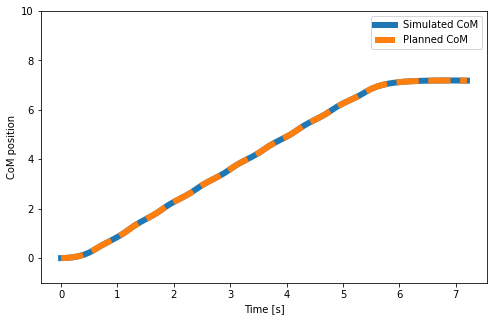

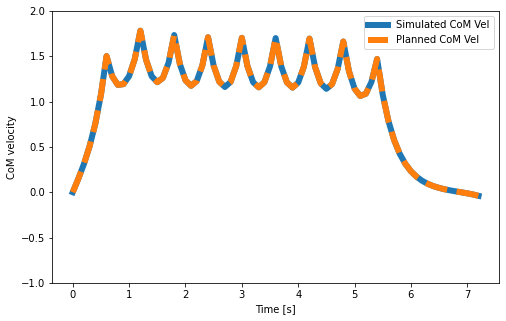

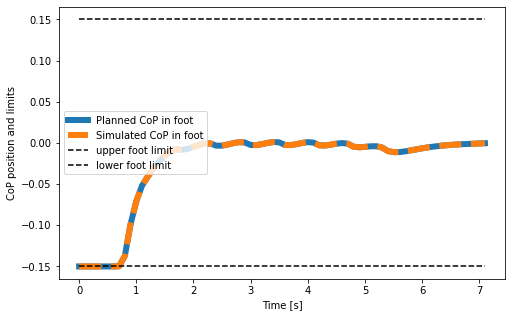

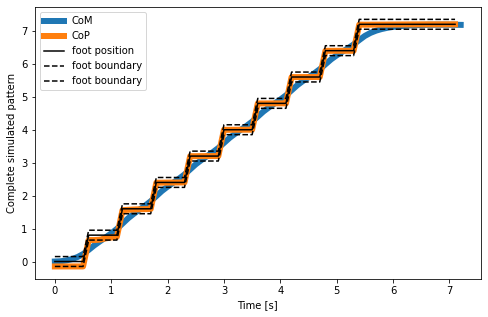

In [6]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# we now define a controller that will simply use the computed u as a control
feedforward_controller = lambda x,i: u_plan[0,i]

# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Q.a Model Predictive Controller

In [0]:
def MPCstep(walking_model, xt, plan_horizon, Q_nominal, R_nominal, foot_position):
  """
  Replan at time step t with state xt.

  Args:
    walking_model: the enironment;
    xt: the initial state at time t;
    plan_horizon: the replanning horizon length;
    Q_nominal: nominal Q matrix;
    R_nominal: nominal R matrix;
    foot_position: a list of foot posistions;

  Returns:
    ut: the control output at time step t
  """

  ## initialize matrixs
  G_bounds = []
  h_bounds = []
  Q = []
  q = []
  R = []
  r = []

  for i in range(plan_horizon):
    Q.append(Q_nominal)
    R.append(R_nominal)

    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    r.append(R_nominal.dot(np.array([-foot_position[i]])))

    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
  
  ## solve mpc with given codes
  x_plan, u_plan = solve_mpc_collocation(walking_model.A, walking_model.B, Q, q,
                                         R, r, G_bounds, h_bounds, plan_horizon, xt)
  
  ## take the first step
  ut = u_plan[:, 0]

  return ut

In [0]:
def MPController(walking_model, horizon_length, plan_horizon, Q_nominal, R_nominal, foot_position):
  """
  A model predictivve controller for stachastic walking environment.

  Args:
    walking_model: the enironment;
    horizon_length: the total length of horizon;
    plan_horizon: the replanning horizon length;
    Q_nominal: nominal Q matrix;
    R_nominal: nominal R matrix;
    foot_position: a list of foot posistions;
  
  Returns:
    controller: a controller function for MPC.
  """

  def controller(x, i):
    horizon = min(plan_horizon, horizon_length-i)
    foot_steps = foot_position[i:i+horizon]

    u = MPCstep(walking_model, x, horizon, Q_nominal, R_nominal, foot_steps)
    return u
  
  return controller

In [9]:
num_experiments = 200
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal, R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


In [10]:
import pandas as pd

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,2.058772e+09,2.149243e+09,1.957309e+09
1,2,1.972737e+09,2.053935e+09,1.891459e+09
2,3,1.860323e+09,1.972938e+09,1.778285e+09
3,4,1.719103e+09,1.812688e+09,1.617210e+09
4,5,1.514004e+09,1.606637e+09,1.448927e+09
5,6,1.239479e+09,1.317630e+09,1.152687e+09
6,7,9.006259e+08,9.976046e+08,8.275151e+08
7,8,5.676025e+08,6.430886e+08,4.811774e+08
8,9,2.984558e+08,3.804809e+08,2.207298e+08
9,10,9.263458e+07,1.585031e+08,2.688554e+07


## Q.b Shortest Horizon

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABJpW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmLZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/k2bTi1K50GX
GBCEPNtd1q13wPmXbo8+Ow2MW/Am7UtYtJjck7mZ1i3flMZMzQHp/WlYwJmhJ1FeSRwrgx3loyn2
d5e8FmL/XfBESGFcXyw/8a13UWTtp3OtYGqGkJ9W5X6j/oldJ1EySX2IZXliG3Z90Caa0Qj7K702
MVRJqpCmkrvsT/ZAe7Y4MCpv2kmZarakcgiZI9rZRKDr+0lI44nbddHGfOX4XBga7t9jTTWtu7Ad
I2orDifspAsY1f/a1YyvLl37Zvh7oqDFECJR8dn1KuOFfez1cWeNACWGNKt0Yw3Gpg41acSycG12
Fd+xJk6p7+0TcyFkV0MF9/jQZnlSpXQ1FyIQrWzq3gDd2t9TM+ntk+dIV3MShiGb+a1cKieY5tKT
IgHTZkVYGXNReTt10KgkxdQEBvW1pLeyZIOEF44jTSoYPo1lManEDWbfwXjjlMjZx3TqPmG12wyB
A5BmwRNwPPWZeX73siej3wcwAua6nAFp7z6RPXA7TRrf78zCHyzVn2QHBKMOAgWdqW5oAv//WlRS
jRCyF1447OHBz2r0XEAf7Jg6XU/Rm8qJWLzrdjBPSpXGLgHUlVpntJ9Xj+QzvohWXoyGeZzlkopo
FgkUHOxaCwP+Vw+AwnAm0JCQL40kSHdrWoAmpD/v5wkw7e2LoR/64ZQljYsmvIry2L8Afko4rldl
IhAc/7EPyvOiQ8ZAQkigm7j/41xP5zSky6QYEdLXpudjMKatifLD5/FXVKt2nlpbWXpPJwzQarSq
DhtC5f+P3gK2A5cuy9NRVjEO/X87ykZr1FA9VxfHuom4NLm77TpctzTXV59A8rhc/OUbOB0Cv/MU
JFloam5R8hRvcVd5W2AJFEFVQi2fv/xvNLdfNsy+ieVtjbN9XOVwCAXs4iMbS4miOfY3bnZAOL23
Fxopp/8ZZosOU+3db8kbo3JQ7mD5DERiaeOLcMuO8eq+NxgiMclvV+Fa8DzXYFosQKa7Ey6xaxAp
iB+7TOwx6M2BJK/a0/e9/iiNhlfzh/P3Fpb0Bjwkcpd+miABe/tr/A58R31mrVw0ggH73IWHoWcK
tP4oLJO49GebHeYERnquEXQkJR7lMANGmry4IhKSetbSW5vBFUy41Ww6MNiUO0TRZM1X/17t8mMO
e/nnFvulhAsk938lCGUawWROwr0RiiPvj2tgc4253vrVrrFS5YixJ+5Rv1kcBrHHeQb/xVw301gf
FgYP/Gy7GcJip+gCHv/LtDI8wv5+hAOw2tm3pPZNEjTW15IZGXGqZlyWRKBGlrLcI4ctI9fn+xqM
cXVa8LyErN3zbxj3yh5W3/pxhSwTvlZ6C3ALg692DSShbHEd7ThpZ0ROzCvyhi3qmWGk5UgERxeE
6auExkR2dsMhNCcx6B+j4LVJ0+IJ2ZTKQ6Oqwj3XSyTW7lPxlrYh/GwtfJdfl+bepKY7YTMYEciW
6nq18DeLkgp8Nc0xO2exNYGr8CbzwqepZqiAasyZRpGGVnjZQdYSAvxzkoIYcH2pbOws2Fkh4Xxj
lv2paU2Byb6YYbqXDNaIdA39+vRmqeoyOtzEsOxOhJvPcGv2P5rtUxbHNNflxdlrtCi+2i7U9AnR
ulRar4XsowUHIzjrCboShRXcmbZgwqRCWTorz/6Td3ffqz1TQKgv/VYM/wrGi+i3QOfUd6+mbhW8
WaDqgeXj6E/6nmrCYDVV2TmdMAnsgkWBdBCOqFBg8QKCr15mY2g7CgwFx4QU+sUnklac9v+Ms0JG
jNN/i64e2fE++xfUwWVzuoAtBcRGf4exm36kGsLWq6y28d5mLlC+EQTrQWjpnEqBM5c/la4frHgS
7r63QtsN74X3mrWr+IfBNdPNgEjrHD22VA4lKnOVxQoJA8rOVpTZ7llmxCbbBWfgGrgiKAychITX
3SIoW49b9BpeRrEj+fDwDHN57Bzsoz2zv7fXgVAeUXSnCHVb0Asq3EUPVFMFRgCZ92DoCRL/pIuY
BYwq421CDdB4tOvfoab4yVo8wG2IAxHoW20Fvj/2CYEEGqOUD/ejD+oEesnsvLIB1wRHAeWIcKo2
suujRQAj6AP30ZvTJc+gIWLDSrGAqgCJ5wkgZWK24egL4/D7HuYvj5RISEpGeQeaxy/QE38iM0eg
c6aAKYA76Gem+vGKwCWmdpSC6Wbgv3OdBdU+ccjmX8j8hvxuUgCY81h+/JH1t9SFBNNEq/maJq70
45XtXfeviK8j1Va+i/rUHfSa5e7iQHkBgw/Ls+qS2mAwGmDmtXg6Qj1VXjQAxgC7j+qUuigaPEkf
J69woGpdnOliU5vKun7LF1uAjxki5wvx5ATnkdLTsi88Ou0PR6UpipjBv8S68pv+dK9ZvutguQSF
6XtBw9dX/1xenbY7PnTrS5tS/U5A506i0iywrAL0lA1pVYhEhYHLB/MCxcIoA+yP6qX5/ToZTaKE
yrxAQ1JXnCHo5sYyAN7HZC9EP9EDrPrUmKLkrbeb1D+qE75o6r7Bdvsz2H9gqggeUp9BV65xGjVY
R7KjohiR1ZLds55ydCW0zqPmSxIpZ9uyL1lEPU6TQ3S5rIshMyYZkYhinbmtCkSLjNcYbLBgsoRz
5iDpTWqtkKfe3bLlNv1hIdDdba7vmJRXYfLU9e6nXiuUf6HLNNILswaL0whaYUBwSzObFUss/9zk
K49CDpx39V16GH/zaFCSWHjzorcHfJAe3PMuANoq9wfyxcw6oqsAALF4PiUTKAtxW0dM6EhyXU5/
9FpLb9TyqViqKfBCgB7jS

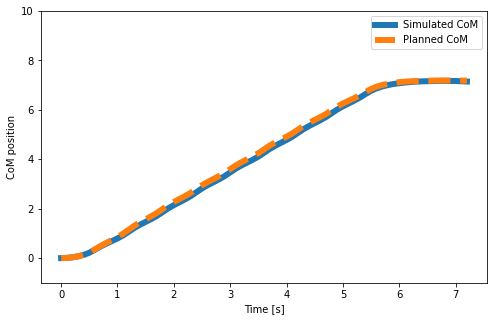

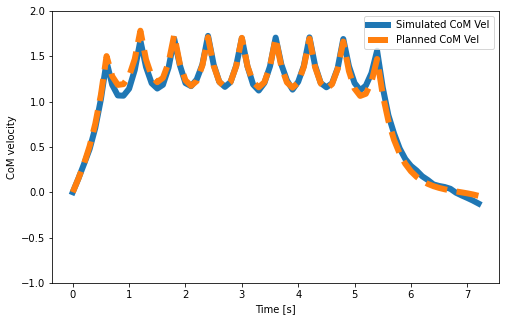

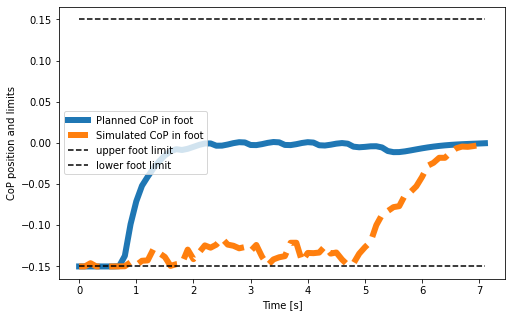

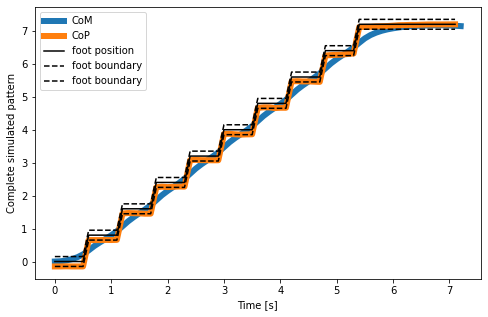

In [11]:
controller = MPController(walking_model, horizon_length, 11, Q_nominal, R_nominal, foot_position)
x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Q.c Stable Horizon

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABFuW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAl3ZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/3LH/iJvv8QDT8a5U4WskWEH
BjO2wkXI5Md7JR1x5NgfDss3z9sgbsTUsWnOeViqg+GyUTMy1xxuvZN4z/9Ep5+0qcWphU2/VogM
i2hkB/quhFOrR8b7no8boU/1wfCaaPQiBEmXXpHe6J7WIdG1IYhBcnjSAGHnbRI9ib4DtMA2fkB3
gQ3gk9aQeBGfplrF3Pb1wuAtgpGFCyTtJ/QfxO10xEWx5cWcIKJqvo5Bmc/p3bfx6qKlBlr6UUQ9
gaf7ID3bHBgVN+3/sc11jH0ETJHtbKgCwSNK7v2lRRj2dsyUe+l6DXdvsaacA+sXmbtpHhxP2UgW
Mav/tascTK6X9O3UtMt9YLZKzG991KuOFfgq2IYwsOu7F6yxIhnBvYEBSnStk4NrsK79iTLAg37Q
5WoP4alyDV/isghGfFPrafuevIT8NbaoJ2nzsaa0cebzj/hVzlUB4Yhu2rsBah5qTYdYPVwHMfAD
h3uDPVzOXixY3jLyzFc8Z+rdRHCQmbJUEsWvF5HxsIwXQA7QDdWJqp5r+INaogTpICXp9Cr6D2oQ
FRH5dUrmA2+zoU9lL956ODIPSDOw/+jYX5klk/yYH3FzDXc6iTfyU/q4+MT/RL/+XJKBAijhwT5O
c4cHPatMzAy7jjfkup+jN5USm3SeczaelSt1vAIc5bsnilAsZGEfP9TWJzMXK8S8ZEuH/cK4y9V+
gs02M61TFEkI7a717VpPSywbm6AJqGmdrAZemwKi6Ef+gefFj6/0PSKi43/68w4aQ5KMNEN/zoM3
hJGMjAUIGQRFVE6u3uYoqyd9/bb9sRI6eKVz2M9yNqitFYkBbYE7eE/eUUS7OkhCwW/480oq/lUp
lHygVB3o2PSgeL61tBNACTS04qhCuXtjcGlzd9p2CFViWRuFUUbNY/NSk1AVsDM81DiTdAT7BmE0
t1Eh0XY0nIUQVVBuR/DCkXC/yv8JTdR6UC/tIA74B6PreRzowLDN+iamHTf9jSBUOU/fw35I3RuS
h3MH0PwMKs1c79L2ZY304Lpskt5Ler8K14HmlmCwK7u12Jl1i1j8emD92mdhj0ZsCScuSQEUjG7u
UQzA59sdjSwUrno8KLsJB7H6LSiWv+RHeu8dOd8TapejiFyFh6FnCrT+KfN75HvFKJ8uROYSq/+6
EhJ3cpgBo01eXBEJSMsbpLc3giqZRZH8VcNiUOz5V8TzHf8Qx/vjH00IJghHnWE0jNXkwbTjmqrk
Bpd9HDhGoyj3ttepa+b3/HaHMcQte/JgZCXmoW2RdxmDHO47wKNQr2kqJ/40AdgQnfm7psz6Ea0X
2wtcDbi3xCbkFni+YOWhAYQ0Nq89zEbkHr4YdYRa4Q9QeTavS234Z6ezT2eySSFq+/YPTQQjv/hu
myARZBDu9sZDjLasukD0arAAz3tJcSVK7Rfn2+a42DoMMwzRMAwkUbrt9MRxDNIyhF2mCB2cF+fx
aM7ayB/mESswNGXP3EjKjf65lhYPaBBNXBUlxXE1Sgx4p07Cgikj4oEIIDjAMbGU0JVg8ueDwuym
0mnl7jZoPP8KJ7lgyiUTM7DXutILZsUSgPFaSdj8U5b8vR5kn0kDci9BNe3TzjFLbGtEOgb+/Xom
TTNokONFn/UDLE3nuDX8Fw9WwXvHIt9bouy18KUklMcXlBcMNAEi+wWV7K38XJlae9SpKHlw+A/H
XqoowYL4af/ycuYP+nU6wLC/dPWrAbjb4myAzvKu47pw+qSrcLOjAoYhu9IrHdCtfQXN9kuQd9Ox
tu90pjVl5vGQr7OVm9dpz/tB3Ga4Zblm40zyhDO3oq78l5vLToLv5nJSbLgWDTurCu95AB63n2EB
T1PBdVrf8B7wsrUE1vxW4WyMZISTNKN59Lpv6BekbkrrHecr9erJydTJCT3ZE3Sbonw1d7+zMkE0
Nbxc2fLQeADxQY5OZf6gnq+j8qeO/JvBMQ3KOBuWui4Ids5P0zWtRZvxZNLyNYj2D4d8vxvPYOdT
EjiusF9eBUB6JdOcIl3yqV524ZIaUucm40pTx3z7/idzQ15gFjC023AhSddQYUNq9v/FySbniVsq
R7ehbbQXWf+bLhftDoJSP5aTqRRHrL7Ly6rid58q59uZvdpFw8t1j+x3035DFmqbs3K5c96vZmaS
DYTeOXEKfxcvnNc/2JUQY6c5AmpRoQk62NAWE4IfPg8tD36T5qj7j1P6TJdtAIAYF/TK2iOdRcKC
xqxlzrDcWi6NNxFHrKZeXPkyn2fW/+Mfb/8Vgum6mLDTGzz0FQkitphdZSFrsqjho5sWPVh6pwEH
FUdvx/NrRxFID+DRoLCU98bYNK8Xb/m3dMGRP/lMK4W3wDUjNXj0PlnzId0GUt+pj+yxdbgI8eng
sL8eQE55HS07su7+iZiVyzzNHT43+JdeU//Vg4uyRU1P5zs1tAFTi1u+AjKfl1/QTd74/YMo7JrW
lXtQ+qK47KEuDaaXirjE+3HZNh+72sWfRv0n+UFoprlpVXiEhqSyVwcxrGFbpjtyOPeXbKQJ13+T
FkxULDPAsnGEg7tYW+Gs7gs+qpZ5170ihIxTW1YRiS5lzXjdjgW6yVI898adA3MmW836XzIIA+BI
y/kAT+XR1h5bnaLITMmGZGIYp25aQpEi4zXGGywYLKMFNg7yC/xq7rmHkgnZAb9sMhmJeCB3kKf2
gtHd+2iI56f/SWtwTjnhXZg0XphC0xj6g9/oc3t1r/+szquSfDGzd+YuvPZv/Dy80z2AydFbg75I
D255lUA1zTKEp7ZhoVsfOAAsXg9dCqNpqBW3QGHFfk9Ht2lU6PhjUj9DB9g6BzMo+iM4ApiQrdy7
f9frp+HX8viGJESE0Qk4V

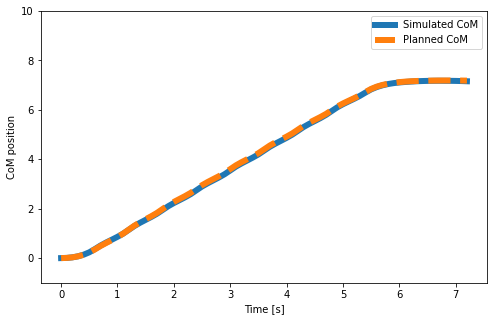

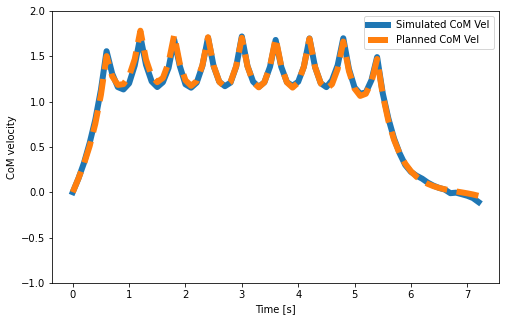

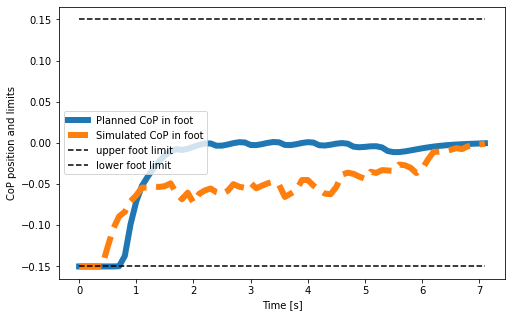

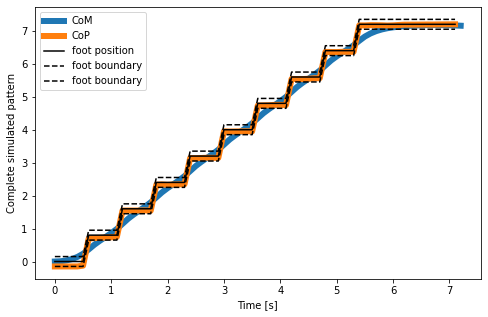

In [12]:
controller = MPController(walking_model, horizon_length, 14, Q_nominal, R_nominal, foot_position)
x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Q.d Control Comparision

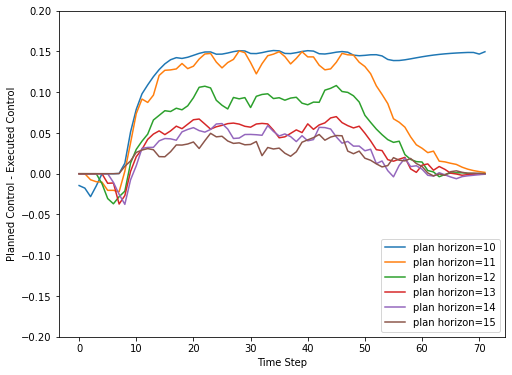

In [13]:
fig = plt.figure(figsize=(8,6))

for plan_horizon in range(10, 16):
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal, R_nominal, foot_position)
  x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)

  plt.plot(u_plan.flatten()-u_real.flatten(), label=f"plan horizon={plan_horizon}")

plt.ylim(-0.2, 0.2)
plt.xlabel("Time Step")
plt.ylabel("Planned Control - Executed Control")
plt.legend(loc="lower right")

## Q.e Weight Change

### 1) Change in Weight Function

In [14]:
num_experiments = 200
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal*(10**1), R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,1.865091e+09,1.944172e+09,1.798579e+09
1,2,1.750938e+09,1.811453e+09,1.680822e+09
2,3,1.606852e+09,1.669505e+09,1.531720e+09
3,4,1.409578e+09,1.481922e+09,1.332195e+09
4,5,1.177904e+09,1.251070e+09,1.116946e+09
5,6,8.990031e+08,9.798802e+08,7.980921e+08
6,7,5.991784e+08,6.592068e+08,5.253378e+08
7,8,3.997121e+08,4.551341e+08,3.637942e+08
8,9,2.461988e+08,2.879464e+08,2.056557e+08
9,10,1.172367e+08,1.650229e+08,7.957173e+07


In [15]:
num_experiments = 200
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal*(10**2), R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,1.817119e+09,1.858306e+09,1.766219e+09
1,2,1.691976e+09,1.737226e+09,1.643138e+09
2,3,1.534392e+09,1.574973e+09,1.480990e+09
3,4,1.371990e+09,1.429669e+09,1.317201e+09
4,5,1.132115e+09,1.209999e+09,1.075883e+09
5,6,8.642764e+08,9.342277e+08,8.065583e+08
6,7,6.087834e+08,6.804346e+08,5.499539e+08
7,8,4.530696e+08,4.951449e+08,4.200978e+08
8,9,3.270858e+08,3.794868e+08,2.872012e+08
9,10,2.029030e+08,2.534994e+08,1.633899e+08


In [16]:
num_experiments = 200
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal*(10**3), R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,1.818963e+09,1.846161e+09,1.787930e+09
1,2,1.689961e+09,1.729923e+09,1.641195e+09
2,3,1.520490e+09,1.564838e+09,1.462551e+09
3,4,1.360813e+09,1.420782e+09,1.320405e+09
4,5,1.133438e+09,1.199587e+09,1.028160e+09
5,6,8.637804e+08,9.125399e+08,7.807034e+08
6,7,5.690873e+08,6.193867e+08,5.087860e+08
7,8,4.501995e+08,4.988490e+08,4.130534e+08
8,9,3.270900e+08,3.699688e+08,2.774175e+08
9,10,2.304649e+08,2.700385e+08,1.944810e+08


In [17]:
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal/(10**1), R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,2.140821e+09,2.263609e+09,2.034247e+09
1,2,2.118175e+09,2.205761e+09,2.030736e+09
2,3,2.086718e+09,2.188857e+09,1.990806e+09
3,4,2.038731e+09,2.126764e+09,1.932497e+09
4,5,1.961330e+09,2.074839e+09,1.875546e+09
5,6,1.840190e+09,1.939203e+09,1.734643e+09
6,7,1.651273e+09,1.721683e+09,1.550935e+09
7,8,1.391662e+09,1.458346e+09,1.315342e+09
8,9,1.077732e+09,1.166820e+09,1.010753e+09
9,10,7.311304e+08,8.126307e+08,6.528276e+08


In [18]:
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal/(10**2), R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,2.163823e+09,2.246459e+09,2.086170e+09
1,2,2.158624e+09,2.243918e+09,2.054238e+09
2,3,2.146612e+09,2.264630e+09,2.017540e+09
3,4,2.138815e+09,2.214069e+09,2.035977e+09
4,5,2.124106e+09,2.223037e+09,2.034344e+09
5,6,2.100439e+09,2.182365e+09,2.002836e+09
6,7,2.051714e+09,2.159575e+09,1.962542e+09
7,8,1.982793e+09,2.064423e+09,1.903999e+09
8,9,1.869949e+09,1.963665e+09,1.768054e+09
9,10,1.700302e+09,1.786926e+09,1.608711e+09


In [19]:
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal/(10**3), R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,2.159299e+09,2.267317e+09,2.057630e+09
1,2,2.157929e+09,2.250031e+09,2.056507e+09
2,3,2.155915e+09,2.260685e+09,2.051861e+09
3,4,2.156920e+09,2.268932e+09,2.067507e+09
4,5,2.159803e+09,2.273855e+09,2.065919e+09
5,6,2.151079e+09,2.250036e+09,2.028173e+09
6,7,2.144382e+09,2.245539e+09,2.036874e+09
7,8,2.133167e+09,2.247740e+09,2.022964e+09
8,9,2.116498e+09,2.216249e+09,2.002044e+09
9,10,2.075490e+09,2.180669e+09,1.985685e+09


### 2) Increase Terminal Cost

In [0]:
def MPCstep(walking_model, xt, plan_horizon, Q_nominal, R_nominal, foot_position):
  """
  Replan at time step t with state xt.

  Args:
    walking_model: the enironment;
    xt: the initial state at time t;
    plan_horizon: the replanning horizon length;
    Q_nominal: nominal Q matrix;
    R_nominal: nominal R matrix;
    foot_position: a list of foot posistions;

  Returns:
    ut: the control output at time step t
  """

  ## initialize matrixs
  G_bounds = []
  h_bounds = []
  Q = []
  q = []
  R = []
  r = []

  for i in range(plan_horizon-1):
    Q.append(Q_nominal)
    R.append(R_nominal)

    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    r.append(R_nominal.dot(np.array([-foot_position[i]])))

    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
  
  ## increase terminal cost
  i = plan_horizon-1
  Q.append(Q_nominal*10**9)
  R.append(R_nominal*10**9)

  q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]]))*10**9)
  r.append(R_nominal.dot(np.array([-foot_position[i]]))*10**9)

  G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
  h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
  
  ## solve mpc with given codes
  x_plan, u_plan = solve_mpc_collocation(walking_model.A, walking_model.B, Q, q,
                                         R, r, G_bounds, h_bounds, plan_horizon, xt)
  
  ## take the first step
  ut = u_plan[:, 0]

  return ut

In [0]:
def MPController(walking_model, horizon_length, plan_horizon, Q_nominal, R_nominal, foot_position):
  """
  A model predictivve controller for stachastic walking environment.

  Args:
    walking_model: the enironment;
    horizon_length: the total length of horizon;
    plan_horizon: the replanning horizon length;
    Q_nominal: nominal Q matrix;
    R_nominal: nominal R matrix;
    foot_position: a list of foot posistions;
  
  Returns:
    controller: a controller function for MPC.
  """

  def controller(x, i):
    horizon = min(plan_horizon, horizon_length-i)
    foot_steps = foot_position[i:i+horizon]

    u = MPCstep(walking_model, x, horizon, Q_nominal, R_nominal, foot_steps)
    return u
  
  return controller

In [22]:
num_experiments = 200
plan_horizons = np.arange(1, 21)

costs = np.zeros((len(plan_horizons), num_experiments))

for i in range(len(plan_horizons)):
  plan_horizon = plan_horizons[i]
  controller = MPController(walking_model, horizon_length, plan_horizon, Q_nominal, R_nominal, foot_position)
  print(f"Experiment on plan_horizon: {plan_horizon}")

  for j in range(num_experiments):
    x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)
    costs[i, j] = np.linalg.norm(x_real - x_plan)

df = pd.DataFrame({"Horizons Length": plan_horizons, 
                   "Mean Cost": np.mean(costs, axis=1), 
                   "Maximum Cost": np.max(costs, axis=1),
                   "Minimum Cost": np.min(costs, axis=1),})
df

Experiment on plan_horizon: 1
Experiment on plan_horizon: 2
Experiment on plan_horizon: 3
Experiment on plan_horizon: 4
Experiment on plan_horizon: 5
Experiment on plan_horizon: 6
Experiment on plan_horizon: 7
Experiment on plan_horizon: 8
Experiment on plan_horizon: 9
Experiment on plan_horizon: 10
Experiment on plan_horizon: 11
Experiment on plan_horizon: 12
Experiment on plan_horizon: 13
Experiment on plan_horizon: 14
Experiment on plan_horizon: 15
Experiment on plan_horizon: 16
Experiment on plan_horizon: 17
Experiment on plan_horizon: 18
Experiment on plan_horizon: 19
Experiment on plan_horizon: 20


,Horizons Length,Mean Cost,Maximum Cost,Minimum Cost
0,1,2.056639e+09,2.184488e+09,1.935848e+09
1,2,1.690352e+09,1.725626e+09,1.648658e+09
2,3,1.519194e+09,1.576387e+09,1.459075e+09
3,4,1.281650e+09,1.359315e+09,1.203544e+09
4,5,9.609625e+08,1.092811e+09,8.545937e+08
5,6,5.172107e+08,6.463986e+08,4.120259e+08
6,7,3.386513e+04,6.772892e+06,6.235058e-01
7,8,3.365127e+05,2.725207e+07,6.898973e-01
8,9,2.654749e+05,1.760718e+07,7.958597e-01
9,10,9.361435e+04,1.872269e+07,8.754854e-01


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABIH21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmLZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/ksaCz3unPnD
8QTymg8lvvz6IzX48k0x2c65VE1/1+BUS9kwkEOLJrVQwSu0dzvK1g8lmCIvurRASfEkv5zdBtIz
GIa5J8E71azT/4z6UxMeql4acGBwced46z6XmnktLHFywbR/f8Km41Gtox0T9rnmCsYu1VUmk8aj
X3gkd8c+dZTlzlmKwtk+uq2e8XCzhrF8InjGkSf2z/cCyLBmhKRhg5+4VvaeeefkNqx6DXdvsaaY
Tb+TbcHMpIvH7KQLGNX/2tWMNUlr+qclu6Kgt2zw4yPZ9SrjhX3sb1l9DQBwtf5kSIZwb2BAOdnE
snBtdhXfsSZX0HBV+spj49kf3Jf0jSsypTvvd26mwVrZ1ZhHfLNP1EIjPbJ8sjMwOpo3jm1qqcqW
LvrBPN5/JUZCfhpTOfL8QGyWC0MF+hkwiKjx3QQAtOxXVq/X4ZeKYoV1a9vbS4ob2TP7wH44EbPZ
/qLmhvnDTtnGiPutGJ0q6jgZLdptxqVKxmQgw5dlFe5LxhFujtueNKNMf9lybIhzHAAXKwLEg/s2
Qs1vjf9S1A+M/8pJaXhP9E2/PZ12a6JLazoeFDVH7S6n6M3lRKmi7rmbT0qVxDQhzl3Ln16WkaSA
C439iztg3chAxL98E0fQQTV+jwM+y44LTNS+kB1M9/G5G8c2mWoLsR+7ppZL33AZMmoQA11qEfDm
Z7zlZ9Ref86nLpDQ0U4Hif6ixiuzPaOQbIpdkv4aMIBZ4NUykuMqexnsqhb8Z6m811J9Jrq++mmw
zt/1agc6ERq7g24/khB6uwaQ8XKn1b7C/qjQZUSbLCcY8q53hmsUKO3IKQAENiS2VsqE8rhc/ORT
kFpRxreS8LMR85s/KhdZckd5W2AJFEFVQrfkKjdjcZmSAdEgMsbGaAsLK7AysZfqzeatfXv2OmO+
a0MI2hQlsvgAUn/2NIFQ5VQUrOKRujclDuYPkHhGJp44twy47x6r43A737yW9X4VrwPM5oiwK7u1
2Jl1i1gtYAD92mdhj0ZsCSSLCICKRjd3KIZgc32OxqQNpBjwkcpd+miABe/tr+2T/nO+s1auGhuw
cLUrpHICZ19Qlozgad7xSXfh+uZWfDqtHZhGplMANGmry4IhKRsTqmW5vBFUzXpmljuNiUO0QPoU
2u/693CSB+vk2quLtf6QKvYgxBOrkxRfl99bbIX/aD+6JgBluEl6Cg3B7tnUc3igUg3H70jXeWRc
V2IAA301gfFgut5GpAyshogU2ADXSPDXW0a3s5coQA6648k6HslnRvEiYNXaVAy6sF5Fr4EAJBYr
WC0zoEAJawFNExCI3Ca+5STtM/k9+5ofz8HcP/U8TtCI/p87U05S61Xq3uEXmoAAI387jMeC4RT3
6UlrGwdBhmESUvzrEgES0TNueuC7V+FEdn0LQkujBSH3f/rjG4lZgaMufuJYyM2wGOhS+5rObVP9
G1PgR4TMYEciW6nan8LDLBsMi1B0ijzB0fkDtYBCYZYCyJQz72T087dx/Nda2EXdhEiNknD0sPrE
I0tS8z+bdI4MqpZs4XGHlzIJlLlk4qNqs2YUE1wQTTNo7DnlmvfcxKsDB/ruFX7FwmXS+gM+NLVw
ez71tTPYqPrmn5snj6bVU3GLzA1bCVLKfeW7mweiJhsZ9gulnv+llzC39Iz/4X+lWKUZCYuyQAiZ
EMQeRHkiNpENWeBBrR6LFUiOyDVEm7Jc2lN+m2udr0f6M93jXDwrh7Y8yT/7qsdus11y3z8VM7OW
/uwwj/EG7t+T+anPb7mZKuMBpF6xQAt7ydgDA6o8kAGP4nx34F9cFcKF6N9gC995Ij0zKC4Iw84h
9cP1jwXvR+NpXwRQfTs65T4U7hpSQizKlI6xw7kmMz7QeADxQY5OY1aFkYJhtH3qBSQA8pQ4kbw0
4MnISE190iNE8lBmYO94xbbVHr6ATZ3/qxqSmxN6wX14FQHlF0pwh1W9ALKtxFD1RTBUQM5O7PVC
7QwRGXmAWMNGDsvg3QeLU7JSbJF19v+X/jGRfj0LbaDQy/6C6DFDlGSTf1SORrjk45aMMKAdcERw
HliHCqNrLrpuLaG3yc9L5jdp2JylznjnqxgKoAiecJIGVituHrklt8JPCUSHgiAIzeVxZ/X59j+Z
wRVLkqyvwZPaqteSjFnZ4NrNvuPTb9to3ciLvToNY8pg+aZUFBK0QGB1PDp3ndQFG4Qcdofsi/kg
iiYfzZfheTVvpLq19E5PI+0meblNPdcBRBD+Ji9UltMBgNMHNavB0hHqqvGo2MZICH9UpdFA0eHC
mIZ6OLG5biCpMpzeVdP2WLrcBHku8FhfjyAnPI6WnZF54ddoej0pTFTGDf4l15Sj86V6zfddE/KD
yQ0AVOLXM/rqlc045FOnWly2j92jM4U5bUV96zGlpaUH2B20SFgcsH8wLFwiEB9kfv0gT+/I0U1y
0kLxAQ1JXnCHo5sYyAN7HZC9AH+DT0dlFyPOpiqYZUP6oT1+PDWdwWfVUs8698Jr0e+MKvXOg0ar
CPZUdEMSOrJbtJPOTopFJjTgOB9J3be6fPNOg9TpNhgZB2iyEzJhmRiGKdujc6JouM1xhssGCyg/
B+Ut44wITnLvJBOyA39P6r7VC213fMSiu00Wp691OvFco/z+WaaQXZg0XphC0wn5glod0n/4j/8X
qlyIp1AZSosVQdP/nI28/R7nnRW4O+SA9ueZXAbRV9s/li5h1RVYAAWLwe/omUBbito6Z0JDk6p0
EqrSW36nlUrFUU+CFAD3e

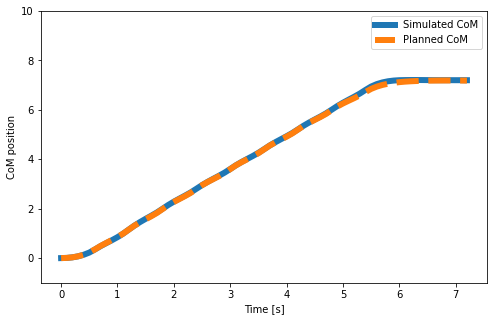

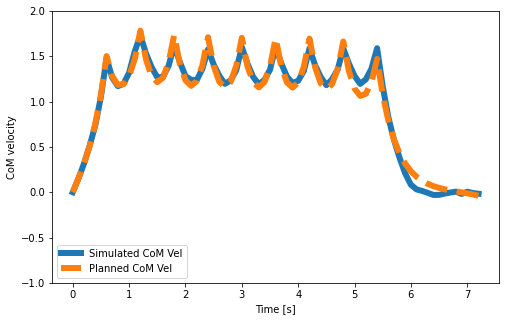

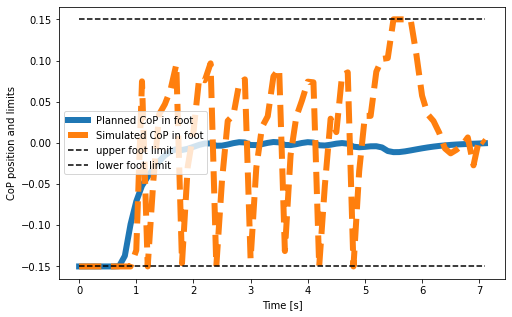

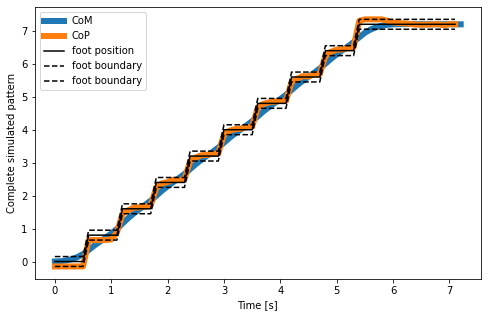

In [23]:
controller = MPController(walking_model, horizon_length, 7, Q_nominal, R_nominal, foot_position)
x_real,u_real = walking_model.simulate(x0, controller, horizon_length, foot_position, noise=True)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

# Exercise 2

In [0]:
def env(x, u):
  """
  The grid-world environemnt.

  Args:
    x: the current state;
    u: the current action.
  
  Returns:
    x_next: the next state;
    cost: the current cost.
  """

  def get_coord(x):
    """
    A helper function to transfer state x to coordinate in grid-world.

    Args:
      x: the current.
    
    Returns:
      i, j: the coordinate in grid-world.
    """

    return x//5, x%5

  i, j = get_coord(x)
  cost = 0

  ## violet
  if (i==0 and j==4) or (i==3 and j==4):
    cost = -1
  ## green
  elif (i==0 and j==2) or (i==1 and j==2) or (i==2and j==3) or (i==3 and j==0):
    cost = 1
  ## red
  elif (i==1 and j==4) or (i==2 and j==1) or (i==3 and j==3):
    cost = 10

  di, dj = 0, 0
  if u == 0:
    di = -1
  elif u == 1:
    di = 1
  elif u == 2:
    dj = -1
  elif u == 3:
    dj = 1
  
  ## obstacles
  if (i+di==1 and j+dj==1) or (i+di==2 and j+dj==2):
    di, dj = 0, 0
  
  ## make a move
  i += di
  j += dj

  ## boundry condition
  if i < 0:
    i = 0
  elif i > 3:
    i = 3
  
  if j < 0:
    j = 0
  elif j > 4:
    j = 4
  
  x_next = int(i * 5 + j)

  return x_next, cost

## Value Iteration

In [0]:
def ValueIteration(env, states, actions, alpha, tol=1e-6):
  """
  Value iteration algorithm.

  Args:
    env: the environment function;
    states: the state indices;
    actions: the action indices;
    alpha: the discount factor;
    tol: converge tolerance.
  
  Returns:
    v: the value function for each state.
  """

  v = np.zeros_like(states, dtype=np.float)
  i = 0
  while True:
    v_new = np.zeros_like(v)
    for s in states:
      q = np.zeros_like(actions, dtype=np.float)
      for a in actions:
        s_next, cost = env(s, a)
        q[a] = cost + alpha * v[s_next]
      
      v_new[s] = np.min(q)

    if np.all(np.abs(v_new-v) < tol):
      break
    v = v_new
    i += 1
  
  print(f"Converge in {i} iterations.")
  
  return v

In [26]:
states = np.arange(5*4)
actions = np.arange(5)
alpha = 0.99

V = ValueIteration(env, states, actions, alpha, tol=1e-6)
V

Converge in 1375 iterations.


array([-95.0794 , -96.0398 , -97.0099 , -98.9999 , -99.9999 , -94.12861, -95.0794 , -96.0298 , -98.0099 , -88.9999 ,
       -93.18732, -82.25545, -96.0398 , -97.0099 , -98.9999 , -91.25545, -90.34289, -89.43946, -88.9999 , -99.9999 ])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


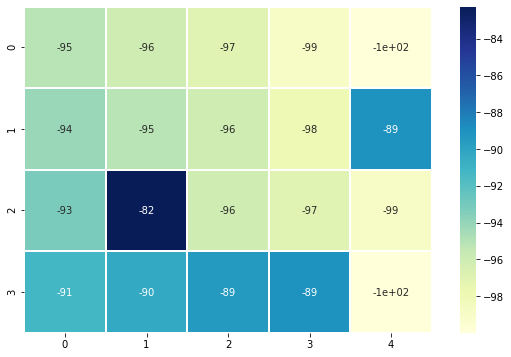

In [27]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(V.reshape(4, 5), annot=True, linewidths=1.0, square=True, cmap="YlGnBu")

In [0]:
def getPolicy(env, states, actions, V):
  """
  Find the current optimal policy with value function.
  """

  policy = np.zeros_like(states)
  for s in states:
    v = np.zeros_like(actions, dtype=np.float)
    for a in actions:
      s_next, _ = env(s, a)
      v[a] = V[s_next]
    
    policy[s] = np.argmin(v)

  return policy

In [0]:
def modifyPolicy(env, states, policy):
  """
  Make modification for policy
  """

  policy = policy.copy()

  for s in states:
    a = policy[s]
    s_next, _ = env(s, a)
    if s_next == s:
      policy[s] = 4
  
  return policy

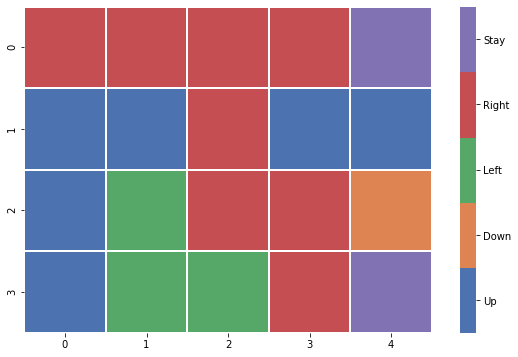

In [30]:
policy = getPolicy(env, states, actions, V)
policy = modifyPolicy(env, states, policy)

plt.figure(figsize=(10,6))
ax = sns.heatmap(policy.reshape(4, 5), linewidths=1.0, square=True, cmap=sns.color_palette("deep", 5))

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.4, 1.2, 2.0, 2.8, 3.6])
colorbar.set_ticklabels(['Up', 'Down', 'Left', 'Right', 'Stay'])

## Policy Iteration

In [0]:
def PolicyIteration(env, states, actions, policy, alpha):
  """
  Policy iteration algorithm.

  Args:
    env: the environment function;
    states: the state indices;
    actions: the action indices;
    policy: the initial policy;
    alpha: the discount factor;
    tol: converge tolerance.
  
  Returns:
    v: the value function for each state.
  """

  def PolicyEvaluate(policy):
    """
    A helper function to evaluate the given policy.
    """
    
    N = len(states)
    T = np.zeros((N, N))
    g = np.zeros_like(states)

    for s in states:
      a = policy[s]
      s_next, g[s] = env(s, a)
      T[s, s_next] = 1
    
    J = np.linalg.inv(np.eye(N) - alpha * T) @ g

    return J
  
  def PolicyUpdate(policy, J):
    """
    A helper function to update current policy.
    """

    new_policy = np.zeros_like(policy)
    for s in states:
      q = np.zeros_like(actions, dtype=np.float)
      for a in actions:
        s_next, cost = env(s, a)
        q[a] = cost + alpha * J[s_next]
      
      new_policy[s] = np.argmin(q)

    return new_policy
  

  i = 0
  while True:
    ## policy evaluation
    J = PolicyEvaluate(policy)
    ## policy update
    new_policy = PolicyUpdate(policy, J)

    if np.all(policy == new_policy):
      break
    
    policy = new_policy
    i += 1
  
  print(f"Converge in {i} iterations.")
  
  return policy, J

In [32]:
states = np.arange(5*4)
actions = np.arange(5)
policy = np.ones_like(states) * 4
alpha = 0.99

policy

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [33]:
policy, J = PolicyIteration(env, states, actions, policy, alpha)
policy = modifyPolicy(env, states, policy)
J

Converge in 8 iterations.


array([ -95.0795 ,  -96.0399 ,  -97.01   ,  -99.     , -100.     ,  -94.12871,  -95.0795 ,  -96.0299 ,  -98.01   ,
        -89.     ,  -93.18742,  -82.25554,  -96.0399 ,  -97.01   ,  -99.     ,  -91.25554,  -90.34299,  -89.43956,
        -89.     , -100.     ])

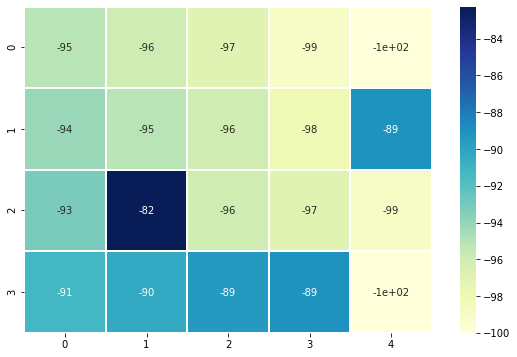

In [34]:
plt.figure(figsize=(10,6))
sns.heatmap(J.reshape(4, 5), annot=True, linewidths=1.0, square=True, cmap="YlGnBu")

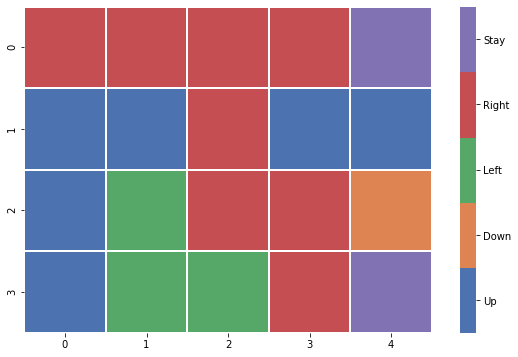

In [35]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(policy.reshape(4, 5), linewidths=1.0, square=True, cmap=sns.color_palette("deep", 5))

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.4, 1.2, 2.0, 2.8, 3.6])
colorbar.set_ticklabels(['Up', 'Down', 'Left', 'Right', 'Stay'])